In [2]:
%%capture
! pip install gym gym[box2d]

In [3]:
%%capture
# simple neural network implementation of qlearning
import gym
import random

import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

from tensorflow.keras import layers, optimizers


# RL using OpenAI Gym: https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/
# Deep Q-Learning: https://github.com/adventuresinML/adventures-in-ml-code/blob/master/r_learning_tensorflow.py

/Users/broxoli/miniforge3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


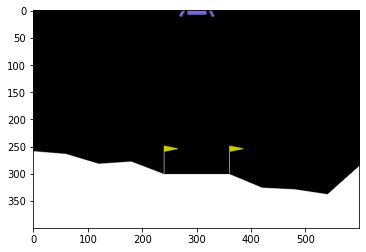

In [4]:
seed = 111

tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

"""
Observation Space has 8 states
===============================

1- The coordinates of the lander in x & y.
2- Its linear velocities in x & y.
3- Its angle.
4- Its angular velocity.
5- Two booleans that represent whether each leg is in contact with the ground or not.

Action Space has 4 discrete actions
===================================
1- Do nothing.
2- Fire left orientation engine.
3- Fire main engine.
4- Fire right orientation engine.

"""

env = gym.make("LunarLander-v2")
observation, info = env.reset(seed=42, return_info=True)
observation, info

image = env.render(mode='rgb_array')
plt.imshow(image)

In [16]:
import random

from IPython.display import HTML, display
from PIL import Image

def save_visuals(env, frames):
    # Save the current game visuals
    frame = env.render(mode='rgb_array')
    frames.append(frame)

def save_frames_as_gif(container, episode_id, frames):
    gif = Image.fromarray(np.copy(frames[0]))
       
    gif_name = 'lunar_lander.{}.{}.gif'.format(episode_id, random.randint(0,2e9))

    gif.save(
        gif_name,
        append_images=list(map(lambda im: Image.fromarray(im), frames[1:])),
        save_all=True, duration=5, loop=0
    )

    container[episode_id] = gif_name

In [24]:
def construct_q_network(state_dim, action_dim):
    """Construct the critic network with q-values per action as output"""
    model = keras.Sequential([
        layers.Input(shape=(state_dim)),
        layers.Dense(32, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(action_dim, activation='linear')
    ])
    
    model.compile(optimizer=optimizers.Adam(.001), loss='mse')

    return model

N_STATES = env.observation_space.shape[0]
N_ACTIONS = env.action_space.n

print(N_STATES, N_ACTIONS)

model = construct_q_network(N_STATES, N_ACTIONS)

8 4


In [25]:
import pickle

GAMMA = 0.95
EXPLORATION_RATE = 0.5

def choose_action(model, state):
    random_action = lambda: np.random.randint(N_ACTIONS)
    
    def predicted_action():
        q_values = model(tf.expand_dims(state, 0))
        action = tf.squeeze(tf.argmax(q_values, axis=-1))
        return action.numpy()

    # Choose between the greey move or the random move.
    # Greedy move take the greedy approach to chose the best current action.
    epsilon = np.random.rand()
    action =  random_action() if epsilon <= EXPLORATION_RATE else predicted_action()

    return action

def obs_to_state(obs):
    state = np.squeeze(obs)
    return state

def play(model, state):
    return choose_action(model, state)

def capped_append(memory, data, max_size=10000):
    memory.append(data)
    if len(memory) > max_size: memory.pop(0)

def normalize_reward(reward, min=-150.0, max=150.0):
    return (reward-min)/(max-min)

def update_exploration_rate(step_id):
    global EXPLORATION_RATE
    if step_id > 1000: EXPLORATION_RATE = .01
    elif step_id > 500: EXPLORATION_RATE = .05
    elif step_id > 300: EXPLORATION_RATE = .1
    elif step_id > 100: EXPLORATION_RATE = .2
    elif step_id > 50: EXPLORATION_RATE = .3
    else: EXPLORATION_RATE = .5

def batch_train(step_id, model, memory, score, bs=64):
    update_exploration_rate(step_id)
    batch = random.sample(memory, bs) if len(memory) > bs else memory

    X = tf.stack([m[0] for m in batch])
    next_X = tf.stack([m[3] for m in batch])

    q_s_a = model.predict(X)
    q_s_a_next = model.predict(next_X)

    for idx, (_, action, reward, _, done) in enumerate(batch):
        if done:
            q_s_a[idx][action] = reward
        else:
            q_s_a[idx][action] = reward + GAMMA*np.amax(q_s_a_next[idx])
    
    history = model.fit(tf.stack(X), q_s_a, batch_size=bs, epochs=1, verbose=0)

    if step_id%4 == 0:
        print('Step: ', step_id, 'Loss: ', history.history['loss'][-1], ' Score: ', score)
    
episodes = 1
memory = []
last_step_memory = []
batch_size = 64
sims = {}
episode_results = []

# Reset the environment to start training from scratch.
obs = env.reset()

for episode_id in range(episodes):
    images = []
    score = 0

    print('\nEpisode: {} \n'.format(episode_id))

    for step_id in range(1000):
        state = obs_to_state(obs)
        action = play(model, state)
        obs, reward, done, _ = env.step(action)
        score += reward

        # Save event data to memory for training later
        capped_append(memory, (state, action, reward, obs_to_state(obs), done))
        
        # Save the current game visuals
        save_visuals(env, images)

        # Train model based on the memory
        if step_id%20 == 0: batch_train(step_id, model, memory, score)

        if done:
            print('Episode:', episode_id, 'Steps:', step_id)
            print('Final Reward:', reward, 'Score:', score)
            episode_results.append((step_id, score, reward, True if reward == 100 else False))
            break

    obs = env.reset()
    save_frames_as_gif(sims, episode_id, images)

with open('lunar_lander.results.pkl', 'wb') as f:
    pickle.dump(episode_results, f)

model.save_weights('lunar_lander.h5')


Episode: 0 



2022-06-21 15:57:35.837653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-21 15:57:36.239891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Step:  0 Loss:  0.9077377319335938  Score:  -1.9416252616447878
Step:  20 Loss:  1.379498839378357  Score:  -48.84642135963982
Step:  40 Loss:  1.0258983373641968  Score:  -55.63297821037716
Step:  60 Loss:  1.1990224123001099  Score:  -101.84139920912295


2022-06-21 15:57:37.323255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-21 15:57:37.560819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Step:  80 Loss:  2.42220401763916  Score:  -197.7800147039634
Episode: 0 Steps: 90
Final Reward: -100 Score: -425.6919657519108


In [26]:
def display_episodes(sims, episodes):
    html_preable = '<div style="display: flex; flex-wrap: wrap;">'
    html_postamble = '</div>'
    html_body = ''
    for episode_id in episodes:
        content_preamble = '<div style="margin: 0 .2%;  width:20%">'
        content_postamble = '</div>'
        gif_name = sims[episode_id]

        content = '<img src="{}"/>\n<p style="text-align: center">Episode: {}</p>'.format(gif_name, episode_id)
        html_body += content_preamble + content + content_postamble

    display(HTML(html_preable + html_body + html_postamble))

display_episodes(sims, range(episodes)[:15])

In [27]:
import pandas as pd

with open('lunar_lander.results.pkl', 'rb') as f:
    results = pickle.load(f)
    pdf = pd.DataFrame(results, columns=['Steps', 'Score', 'Final Reward', 'Finished'])
    display(pdf)

,Steps,Score,Final Reward,Finished
0,90,-425.691966,-100,False
